In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(8,6)})
sns.set_theme(style="white")

In [2]:
df = pd.read_csv('car_data.csv').drop(columns=['Unnamed: 0'])
df.sample(5)

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
42246,IX20,2015.0,Automatic,17950.0,Petrol,NaN,43.6,1.6,7480.0
15737,3 Series,2014.0,Semi-Auto,52106.0,Diesel,30.0,62.8,2.0,12890.0
13694,M4,2015.0,Manual,27489.0,Petrol,325.0,31.0,3.0,27590.0
14470,4 Series,2019.0,Null,590.0,Diesel,145.0,47.9,3.0,37990.0
15119,3 Series,2018.0,Semi-Auto,31500.0,Diesel,145.0,74.3,2.0,16980.0


# Linear Regression: Predict Used Car Prices

## Part 1: Split the Data into a Training and Testing set

In [3]:
X, y = df.drop('price', axis='columns'), df['price']
y

0        12500.0
1        16500.0
2        11000.0
3        16800.0
4        17300.0
          ...   
51007     5500.0
51008     4985.0
51009     4995.0
51010     3995.0
51011     4495.0
Name: price, Length: 51012, dtype: float64

In [4]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    test_size=0.2, 
    train_size=0.8, 
    random_state=10, 
    shuffle=True)


In [5]:
X_test

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
2308,TT,2016.0,Manual,51400.0,Diesel,30.0,62.8,2.0
33347,Fiesta,2018.0,Manual,4096.0,Petrol,145.0,58.9,1.0
44382,Corolla,2019.0,Automatic,11408.0,Hybrid,135.0,85.6,1.8
13611,1 Series,2019.0,Manual,3382.0,Diesel,145.0,70.6,1.5
39511,I30,2018.0,Manual,15804.0,Petrol,NaN,57.7,1.0
...,...,...,...,...,...,...,...,...
30611,EcoSport,2014.0,Manual,10225.0,Petrol,125.0,53.3,1.0
22860,Fiesta,2016.0,Null,37981.0,Petrol,0.0,65.7,1.0
9911,Q3,2017.0,Automatic,27868.0,Petrol,145.0,47.9,1.4
16521,Z4,2020.0,Semi-Auto,1801.0,Petrol,150.0,33.2,3.0


## Part 2: Null Value Inputation
Note: The transmission column doesn't contain NaN values, but "Null" Strings

### Step 1: One-hot encoding

In [6]:
def filled_tax(df):
    df['tax'] = df['tax'].fillna(0)
    return df
filled_tax(X_train)

/var/folders/gh/k7rgm7qs3zl2lw8bn_ydlg_40000gq/T/ipykernel_47970/2696713979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tax'] = df['tax'].fillna(0)


,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
28154,Fiesta,2014.0,Manual,30713.0,Petrol,30.0,54.3,1.2
14274,2 Series,2020.0,Manual,103.0,Petrol,145.0,52.3,1.5
36606,Focus,2017.0,Manual,46713.0,Petrol,20.0,60.1,1.0
49934,C-HR,2018.0,Automatic,21995.0,Hybrid,135.0,74.3,1.8
50741,Verso,2017.0,Manual,41630.0,Diesel,30.0,62.8,1.6
...,...,...,...,...,...,...,...,...
28017,Kuga,2018.0,Manual,4034.0,Petrol,145.0,39.2,1.5
50496,Prius,2017.0,Null,33875.0,Hybrid,0.0,94.1,1.8
29199,Fiesta,2016.0,Manual,24610.0,Petrol,0.0,65.7,1.0
40061,Santa Fe,2017.0,Semi-Auto,12957.0,Diesel,0.0,42.8,2.2


In [7]:
# one-hot-encoder object
# we fit it once to the training data and only transform after that because it only needs to be fitted once
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
# fit encoder to our training data without transmission data
encoder.fit(df[['model', 'fuelType']])

OneHotEncoder()

In [8]:
# function that ohe's but not transmission
def ohe_except_transmission(df):
    ohe_values = encoder.transform(df[['model', 'fuelType']])
    ohe_df = pd.DataFrame(ohe_values.toarray(), columns=encoder.get_feature_names())
    ohe_df = ohe_df.set_index(df.index)
    return df.drop(['model', 'fuelType'], axis='columns').merge(right=ohe_df, right_index=True, left_index=True)
knn_dataset_transmission = ohe_except_transmission(X_train)
knn_dataset_transmission

,year,transmission,mileage,tax,mpg,engineSize,x0_ 1 Series,x0_ 2 Series,x0_ 3 Series,x0_ 4 Series,...,x0_ Yaris,x0_ Z3,x0_ Z4,x0_ i3,x0_ i8,x1_Diesel,x1_Electric,x1_Hybrid,x1_Other,x1_Petrol
28154,2014.0,Manual,30713.0,30.0,54.3,1.2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14274,2020.0,Manual,103.0,145.0,52.3,1.5,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36606,2017.0,Manual,46713.0,20.0,60.1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
49934,2018.0,Automatic,21995.0,135.0,74.3,1.8,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
50741,2017.0,Manual,41630.0,30.0,62.8,1.6,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28017,2018.0,Manual,4034.0,145.0,39.2,1.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
50496,2017.0,Null,33875.0,0.0,94.1,1.8,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
29199,2016.0,Manual,24610.0,0.0,65.7,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40061,2017.0,Semi-Auto,12957.0,0.0,42.8,2.2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Step 2: Create KNN Dataset

In [9]:
# drop rows with null in transmission and drop transmission column after
def fuck_transmission(df):
    return df[df['transmission'] != 'Null'].drop('transmission', axis='columns')
knn_dataset = fuck_transmission(knn_dataset_transmission)
knn_dataset

,year,mileage,tax,mpg,engineSize,x0_ 1 Series,x0_ 2 Series,x0_ 3 Series,x0_ 4 Series,x0_ 5 Series,...,x0_ Yaris,x0_ Z3,x0_ Z4,x0_ i3,x0_ i8,x1_Diesel,x1_Electric,x1_Hybrid,x1_Other,x1_Petrol
28154,2014.0,30713.0,30.0,54.3,1.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14274,2020.0,103.0,145.0,52.3,1.5,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36606,2017.0,46713.0,20.0,60.1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
49934,2018.0,21995.0,135.0,74.3,1.8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
50741,2017.0,41630.0,30.0,62.8,1.6,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40059,2018.0,13668.0,0.0,48.7,1.6,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
28017,2018.0,4034.0,145.0,39.2,1.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
29199,2016.0,24610.0,0.0,65.7,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40061,2017.0,12957.0,0.0,42.8,2.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Step 3: Create KNN Model
Scikit-learn has a KNeighborsClassifier; please do not build your own.

In [10]:
# create a knn classifier object
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=15)
knn

KNeighborsClassifier(n_neighbors=15)

In [11]:
# fit knn to our data
y_train_knn = X_train[X_train['transmission'] != 'Null']['transmission']
knn.fit(knn_dataset, y_train_knn)

KNeighborsClassifier(n_neighbors=15)

### Step 4: Replace Null Values using the KNN Model

In [12]:
knn_dataset

,year,mileage,tax,mpg,engineSize,x0_ 1 Series,x0_ 2 Series,x0_ 3 Series,x0_ 4 Series,x0_ 5 Series,...,x0_ Yaris,x0_ Z3,x0_ Z4,x0_ i3,x0_ i8,x1_Diesel,x1_Electric,x1_Hybrid,x1_Other,x1_Petrol
28154,2014.0,30713.0,30.0,54.3,1.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14274,2020.0,103.0,145.0,52.3,1.5,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36606,2017.0,46713.0,20.0,60.1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
49934,2018.0,21995.0,135.0,74.3,1.8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
50741,2017.0,41630.0,30.0,62.8,1.6,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40059,2018.0,13668.0,0.0,48.7,1.6,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
28017,2018.0,4034.0,145.0,39.2,1.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
29199,2016.0,24610.0,0.0,65.7,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40061,2017.0,12957.0,0.0,42.8,2.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [13]:
# create dataframe with only null for transmission and drop transmission after
def only_null(df):
    return df[df['transmission'] == 'Null'].drop('transmission', axis='columns')
null_trans = only_null(knn_dataset_transmission)
X_train.loc[null_trans.index, 'transmission'] = knn.predict(null_trans)

/Users/joez/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [14]:
X_train

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
28154,Fiesta,2014.0,Manual,30713.0,Petrol,30.0,54.3,1.2
14274,2 Series,2020.0,Manual,103.0,Petrol,145.0,52.3,1.5
36606,Focus,2017.0,Manual,46713.0,Petrol,20.0,60.1,1.0
49934,C-HR,2018.0,Automatic,21995.0,Hybrid,135.0,74.3,1.8
50741,Verso,2017.0,Manual,41630.0,Diesel,30.0,62.8,1.6
...,...,...,...,...,...,...,...,...
28017,Kuga,2018.0,Manual,4034.0,Petrol,145.0,39.2,1.5
50496,Prius,2017.0,Manual,33875.0,Hybrid,0.0,94.1,1.8
29199,Fiesta,2016.0,Manual,24610.0,Petrol,0.0,65.7,1.0
40061,Santa Fe,2017.0,Semi-Auto,12957.0,Diesel,0.0,42.8,2.2


In [15]:
# This function creates a dataframe to the current standards
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    test_size=0.2, 
    train_size=0.8, 
    random_state=10, 
    shuffle=True)

def make_pretty(df):
    df = filled_tax(df)
    df = ohe_except_transmission(df)
    df.loc[only_null(df).index, 'transmission'] = knn.predict(only_null(df))
    return df
X_train = make_pretty(X_train)
X_test = make_pretty(X_test)

/var/folders/gh/k7rgm7qs3zl2lw8bn_ydlg_40000gq/T/ipykernel_47970/2696713979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tax'] = df['tax'].fillna(0)
/var/folders/gh/k7rgm7qs3zl2lw8bn_ydlg_40000gq/T/ipykernel_47970/2696713979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tax'] = df['tax'].fillna(0)


## Part 3: Clean up the Rest of the Data for Regression  
One-hot encode categorical features, check all features for linearity (aside from one-hot encoded ones), and do any other data cleaning and preprocessing necessary.

In [16]:
trans_enc = OneHotEncoder()
trans_enc.fit(df[['transmission']])

OneHotEncoder()

In [17]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    test_size=0.2, 
    train_size=0.8, 
    random_state=10, 
    shuffle=True)

# one-hot-encodes transmission
def make_very_pretty(df):
    df = make_pretty(df)
    ohe_values = trans_enc.transform(df[['transmission']])
    ohe_df = pd.DataFrame(ohe_values.toarray(), columns=trans_enc.get_feature_names())
    ohe_df = ohe_df.set_index(df.index)
    return df.drop('transmission', axis='columns').merge(right=ohe_df, right_index=True, left_index=True)
X_train = make_very_pretty(X_train)
X_test = make_very_pretty(X_test)

/var/folders/gh/k7rgm7qs3zl2lw8bn_ydlg_40000gq/T/ipykernel_47970/2696713979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tax'] = df['tax'].fillna(0)
/var/folders/gh/k7rgm7qs3zl2lw8bn_ydlg_40000gq/T/ipykernel_47970/2696713979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tax'] = df['tax'].fillna(0)


In [18]:
# calculate correlation
def corr(df, label1, label2):
    mean1 = np.mean(df[label1])
    mean2 = np.mean(df[label2])
    std1 = np.std(df[label1])
    std2 = np.std(df[label2])
    return (
        sum((df[label1] - mean1)*(df[label2] - mean2)) / 
        np.sqrt(sum((df[label1] - mean1)**2)*sum((df[label2] - mean2)**2))
    )
corr(X_train, 'mileage', 'engineSize')

0.12300515475281044

/Users/joez/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='tax', ylabel='year'>

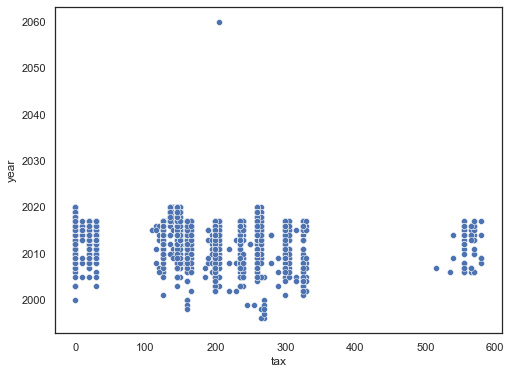

In [19]:
# check for linearity
lin = X_train.loc[:, 'year':'engineSize']

sns.scatterplot(lin['tax'], lin['year'])

In [20]:
# this is ellie's work
y_test = np.log(y_test + np.min(y_test))
y_train = np.log(y_train + np.min(y_train))
X_test['mileage'] = (np.log(X_test['mileage'])**3)
X_test['mpg'] = (np.log(X_test['mpg']+np.min(X_test['mpg']+1)))
X_test['tax']= (np.log(X_test['tax']+1))
X_train['mileage'] = (np.log(X_train['mileage'])**3)
X_train['mpg'] = (np.log(X_train['mpg']+np.min(X_test['mpg']+1)))
X_train['tax']= (np.log(X_train['tax']+1))
X_train

,year,mileage,tax,mpg,engineSize,x0_ 1 Series,x0_ 2 Series,x0_ 3 Series,x0_ 4 Series,x0_ 5 Series,...,x1_Diesel,x1_Electric,x1_Hybrid,x1_Other,x1_Petrol,x0_Automatic,x0_Manual,x0_Null,x0_Other,x0_Semi-Auto
28154,2014.0,1103.084646,3.433987,4.046328,1.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
14274,2020.0,99.557282,4.983607,4.010729,1.5,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
36606,2017.0,1242.913310,3.044522,4.142929,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
49934,2018.0,999.571191,4.912655,4.346232,1.8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
50741,2017.0,1203.387745,3.433987,4.184902,1.6,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28017,2018.0,572.306668,4.983607,3.739741,1.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
50496,2017.0,1134.767680,0.000000,4.574578,1.8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
29199,2016.0,1033.642826,0.000000,4.228104,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
40061,2017.0,849.114411,0.000000,3.821815,2.2,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Part 4: Build a Linear Regression Model Using the Test Set
Experiment with LASSO and Ridge regression.

In [21]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def scale_df(df):
    scaled = scaler.fit_transform(df.to_numpy())
    df = pd.DataFrame(scaled, columns=df.columns)
    return df
    
X_train_scaled = scale_df(X_train)
X_test_scaled = scale_df(X_test)
y_train_scaled = scale_df(pd.DataFrame(y_train))['price']
y_test_scaled = scale_df(pd.DataFrame(y_test))['price']
X_test_scaled

,year,mileage,tax,mpg,engineSize,x0_ 1 Series,x0_ 2 Series,x0_ 3 Series,x0_ 4 Series,x0_ 5 Series,...,x1_Diesel,x1_Electric,x1_Hybrid,x1_Other,x1_Petrol,x0_Automatic,x0_Manual,x0_Null,x0_Other,x0_Semi-Auto
0,0.826087,0.625263,0.539532,0.540682,0.317460,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.913043,0.281908,0.783001,0.526568,0.158730,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.956522,0.399407,0.771853,0.609545,0.285714,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.956522,0.262877,0.783001,0.566587,0.238095,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.913043,0.442689,0.000000,0.522048,0.158730,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10198,0.739130,0.385529,0.759854,0.504686,0.158730,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
10199,0.826087,0.574390,0.000000,0.550652,0.158730,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
10200,0.869565,0.525267,0.783001,0.481449,0.222222,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
10201,1.000000,0.206344,0.788292,0.403201,0.476190,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [22]:
# apply ridge and lasso

def apply_model(X, y, model, alpha):
    fitted = model(alpha)
    fitted.fit(X, y)
    return fitted

def rmse(y, y_pred):
    return np.sqrt(np.mean((y - y_pred)**2))

l = []
r = []
for el in np.arange(0.1, 1001, 10):
    model = apply_model(X_train_scaled, y_train_scaled, Lasso, el)
    l.append([[rmse(y_test_scaled, model.predict(X_test_scaled)), el]])
    model = apply_model(X_train_scaled, y_train_scaled, Ridge, el)
    r.append([[rmse(y_test_scaled, model.predict(X_test_scaled)), el]])

print('lasso', min(l, key=lambda x: x[0]))
print('ridge', min(r, key=lambda x: x[0]))
    

lasso [[0.11369232428337235, 0.1]]
ridge [[0.08547645828461904, 1000.1]]


In [23]:
# in the range from 0.1 to 1000.1, at 10-based increments, 
# 0.1 is the best alpha value 
# for lasso and 1000.1 is the best for ridge

# it seems like for lasso, the smaller the alpha, the better the prediction, 
# and for ridge, the higher the alpha the better the prediciton

# therefore we use ridge on sclaed data with alpha=1000


# Logistic Regression: Classify the fuel type of a car

## Use the following modified car dataset to build a logistic regression model that predicts whether a row classifies to Petrol or Diesel.

In [26]:
classify_df = df[df['fuelType'].isin(['Petrol', 'Diesel'])]
classify_df.head()

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,A1,2017.0,Null,15735.0,Petrol,150.0,55.4,1.4,12500.0
1,A6,2016.0,Null,36203.0,Diesel,20.0,64.2,2.0,16500.0
2,A1,2016.0,Null,29946.0,Petrol,30.0,55.4,1.4,11000.0
3,A4,2017.0,Null,25952.0,Diesel,145.0,67.3,2.0,16800.0
4,A3,2019.0,Null,1998.0,Petrol,145.0,49.6,1.0,17300.0


In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

classify_df = filled_tax(classify_df)

def ohe(df):
    ohe_values = model_enc.transform(df)
    ohe_df = pd.DataFrame(ohe_values.toarray(), columns=model_enc.get_feature_names())
    ohe_df = ohe_df.set_index(df.index)
    return ohe_df
def ohet(df):
    ohe_values = trans_enc.transform(df)
    ohe_df = pd.DataFrame(ohe_values.toarray(), columns=trans_enc.get_feature_names())
    ohe_df = ohe_df.set_index(df.index)
    return ohe_df

model_enc = OneHotEncoder()
model_enc.fit(classify_df[['model']])
classify_df = classify_df.merge(right=ohe(classify_df[['model']]), right_index=True, left_index=True) \
                                .drop('model', axis='columns')

Xl = classify_df.drop(['fuelType'], axis='columns')
yl = classify_df['fuelType']

knnl = KNeighborsClassifier(n_neighbors=15)
wo_null = Xl[classify_df['transmission'] != "Null"]
knnl.fit(wo_null.drop('transmission', axis='columns'), wo_null['transmission'])

Xl.loc[Xl[Xl['transmission'] == 'Null'].index, 'transmission'] = knnl.predict(Xl[Xl['transmission'] == 'Null'].drop('transmission', axis='columns'))

trans_enc = OneHotEncoder()
trans_enc.fit(Xl[['transmission']])
Xl = Xl.merge(right=ohet(Xl[['transmission']]), right_index=True, left_index=True) \
                                .drop('transmission', axis='columns')

X_ltrain, X_ltest, y_ltrain, y_ltest = model_selection.train_test_split(Xl, yl, 
    test_size=0.2, 
    train_size=0.8, 
    random_state=10, 
    shuffle=True)

/var/folders/gh/k7rgm7qs3zl2lw8bn_ydlg_40000gq/T/ipykernel_47970/2696713979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tax'] = df['tax'].fillna(0)


In [28]:
model = LogisticRegression(solver='liblinear', random_state=0).fit(X_ltrain, y_ltrain)

In [29]:
# accuracy
model.score(X_ltest, y_ltest)

0.906077922077922